<a href="https://colab.research.google.com/github/Mechtanium/DeepLearning/blob/main/Autoencoder_pytorch_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

2024-07-06 12:45:13.053789: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-06 12:45:13.053900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 12:45:13.183736: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# get mnist dataset from tensorflow for convenience
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# convert to numpy array with grayscale from 0 to 1 for compatibility with PyTorch
train_images = (np.expand_dims(train_images, axis=-1)/255.).astype(np.float32)
train_labels = (train_labels).astype(np.int64)
test_images = (np.expand_dims(test_images, axis=-1)/255.).astype(np.float32)
test_labels = (test_labels).astype(np.int64)

# verify numpy conversion
print(type(train_images), len(train_images), type(train_labels), type(test_images), len(test_images), type(test_labels))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
<class 'numpy.ndarray'> 60000 <class 'numpy.ndarray'> <class 'numpy.ndarray'> 10000 <class 'numpy.ndarray'>


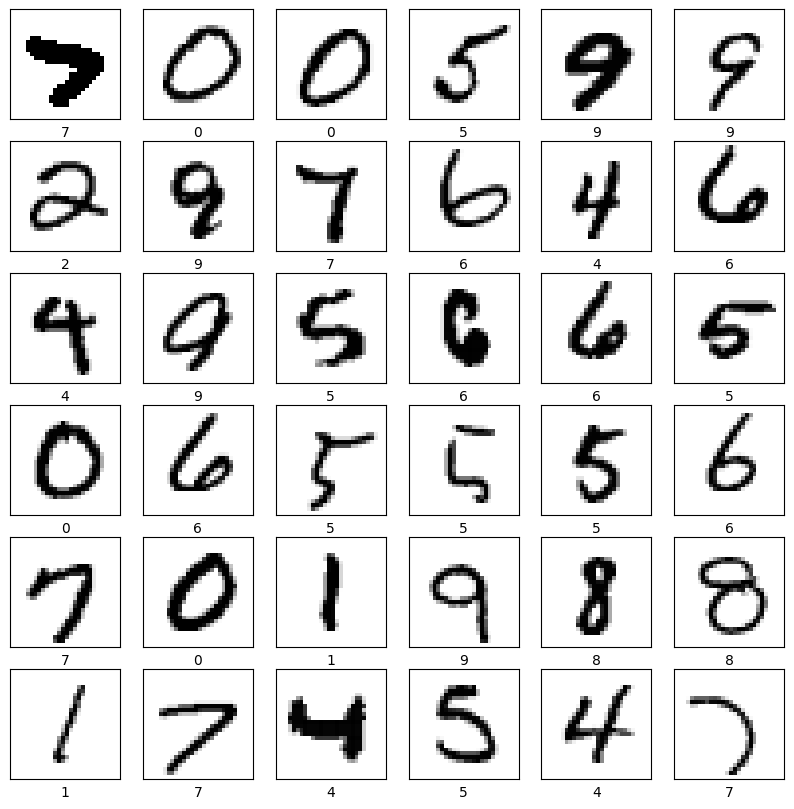

In [ ]:
# take a peek at mnist
def peek(images, labels):
    plt.figure(figsize=(10,10))
    random_inds = np.random.choice(len(images), 36)
    for i in range(36):
        plt.subplot(6,6,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        image_ind = random_inds[i]
        plt.imshow(np.squeeze(images[image_ind]), cmap=plt.cm.binary)
        plt.xlabel(labels[image_ind])

peek(train_images, train_labels)

Train
Test


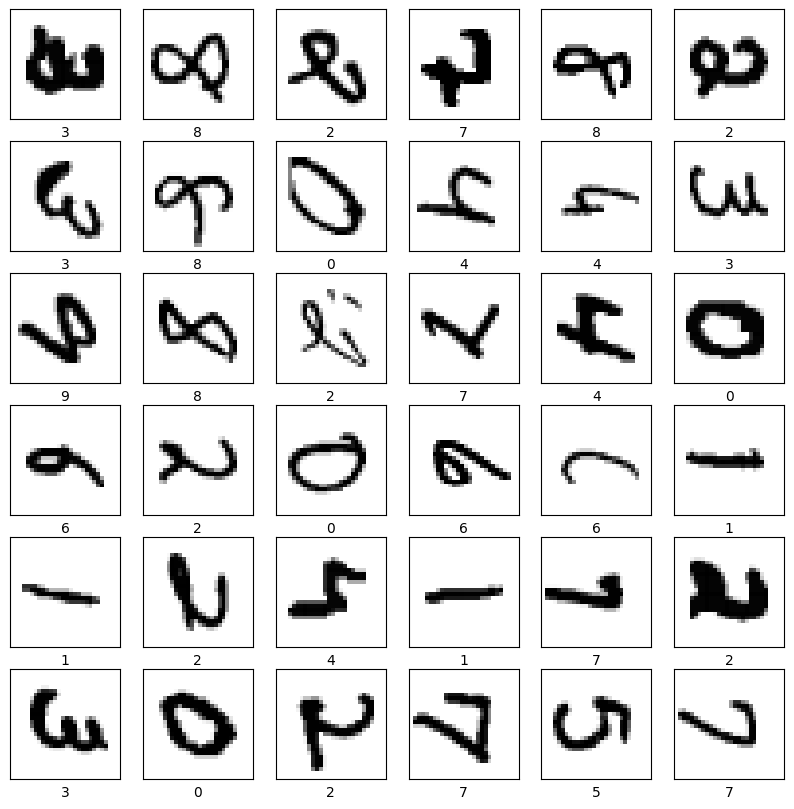

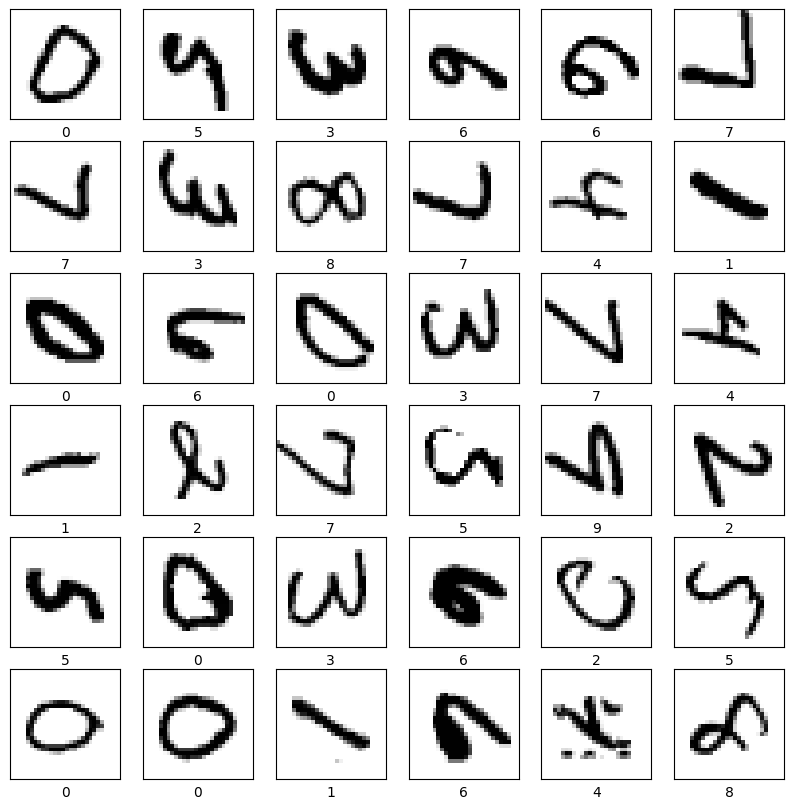

In [ ]:
# rotate mnist
def rotate_image(image, angle):
    n = image.shape[0]

    # Create a new matrix to hold the rotated image
    rotated_image = [[None]*n for _ in range(n)]

    for i in range(n):
        for j in range(n):
            rotated_image[j][n - i - 1] = image[i][j]

    return rotated_image

rotated_train_images = []
for idx, t in enumerate(train_images):
    rotated_train_images.append(rotate_image(t, 90))
rotated_train_images = np.array(rotated_train_images)

print("Train")
peek(rotated_train_images, train_labels)

rotated_test_images = []
for idx, t in enumerate(test_images):
    rotated_test_images.append(rotate_image(t, 90))
rotated_test_images = np.array(rotated_test_images)

print("Test")
peek(rotated_test_images, test_labels)

In [ ]:
import torch
train_tensors = torch.tensor(train_images, dtype=torch.float32)
r_train_tensors = torch.tensor(rotated_train_images, dtype=torch.float32)
test_tensors = torch.tensor(test_images, dtype=torch.float32)
r_test_tensors = torch.tensor(rotated_test_images, dtype=torch.float32)

if torch.cuda.is_available():
    train_tensors = train_tensors.to("cuda")
    test_tensors = test_tensors.to("cuda")
    r_train_tensors = r_train_tensors.to("cuda")
    r_test_tensors = r_test_tensors.to("cuda")

In [ ]:
print(train_tensors[0].shape)
print(test_tensors[0].shape)
print(r_train_tensors[0].shape)
print(r_test_tensors[0].shape)

torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])


In [ ]:
!pip install --quiet mitdeeplearning
import mitdeeplearning as mdl
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(128, bias=True),
    nn.Sigmoid(),
    nn.LazyLinear(64, bias=True),
    nn.Sigmoid(),
    nn.LazyLinear(10, bias=True),
    nn.Sigmoid(),
    nn.LazyLinear(64, bias=True),
    nn.Sigmoid(),
    nn.LazyLinear(128, bias=True),
    nn.Sigmoid(),
    nn.LazyLinear(784, bias=True)
)

model.to(device)

optimizer = optim.SGD(model.parameters(), lr=1, momentum=0.9)
flatten = nn.Flatten()
loss_fn = nn.MSELoss()

cuda


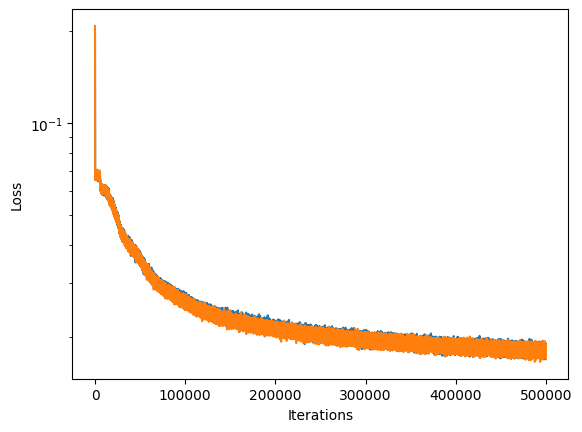

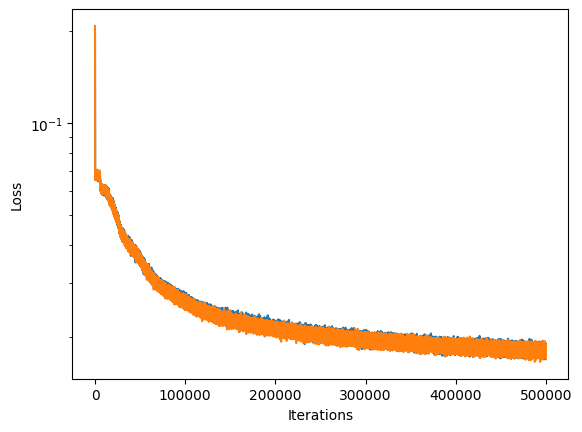

In [ ]:
loss_history = mdl.util.LossHistory(smoothing_factor=0.9) # to record the evolution of the loss
test_loss_history = mdl.util.LossHistory(smoothing_factor=0.9) # to record the evolution of the loss
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss', scale='semilogy')

for epoch in range(500000):
    random_inds = np.random.choice(len(train_tensors), 32)
    sub_train = train_tensors[random_inds]
    r_sub_train = flatten(r_train_tensors[random_inds])
    logits = model(sub_train)
    loss = loss_fn(logits, r_sub_train)
    loss_history.append(loss.item())

    test_random_inds = np.random.choice(len(test_tensors), 32)
    sub_test = test_tensors[test_random_inds]
    r_sub_test = flatten(r_test_tensors[test_random_inds])
    test_logits = model(sub_test)
    test_loss = loss_fn(test_logits, r_sub_test)
    test_loss_history.append(test_loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}")
    if epoch % 100 == 0:
        losses = [(train_loss, test_loss) for train_loss, test_loss in zip(loss_history.get(), test_loss_history.get())]
        plotter.plot(losses)

In [ ]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: 1.weight | Size: torch.Size([128, 784]) | Values : tensor([[ 0.0225,  0.0227,  0.0268,  ..., -0.0297, -0.0294, -0.0098],
        [ 0.0355,  0.0152,  0.0212,  ..., -0.0354,  0.0092, -0.0105]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: 1.bias | Size: torch.Size([128]) | Values : tensor([0.6416, 0.9914], device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: 3.weight | Size: torch.Size([64, 128]) | Values : tensor([[-0.2343, -0.4805,  0.1334, -0.4382,  0.2854,  0.3205,  0.0993,  0.0036,
          0.0268, -0.1626,  0.3650,  0.4517,  0.0016,  0.0373,  0.0546, -0.0981,
         -1.1438, -0.0753,  0.1615,  0.0901,  0.0072,  0.2471, -0.0147, -0.2518,
          0.1586,  0.1199,  0.1873, -0.1066, -0.1480, -0.1209,  0.2125,  0.1476,
          0.0238, -0.1128,  0.0837, -0.1304, -0.3629, -0.0217,  0.1785, -0.0189,
          0.4850,  0.2260,  0.0953, -0.2094, -0.1923,  0.0536, -0.1358, -0.3840,
          0.2047,  0.0045,  0.0050, -0.6318,  0.1117,  0.3090,  0.1214, -0.1733,
    

<Figure size 1000x1000 with 0 Axes>

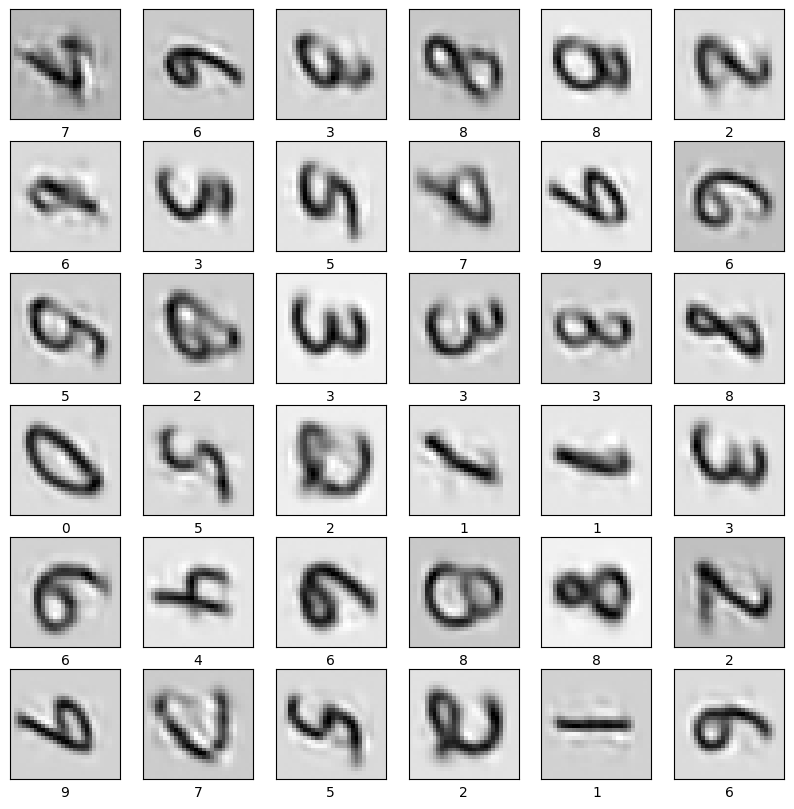

In [ ]:
plt.figure(figsize=(10,10))
logits = model(test_tensors)
test_output = logits.view(len(logits), 28, 28, 1)

peek(test_output.cpu().detach().numpy(), test_labels)